# Mount Drive & Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
ngkinwang_iam_dataset_path = kagglehub.dataset_download('ngkinwang/iam-dataset')
loaytamer_parser_path = kagglehub.dataset_download('loaytamer/parser')
loaytamer_custom_dataset_path = kagglehub.dataset_download('loaytamer/custom-dataset')

print('Data source import complete.')

100%|██████████| 1.10G/1.10G [01:01<00:00, 19.3MB/s]

Extracting files...


100%|██████████| 1.65M/1.65M [00:01<00:00, 1.58MB/s]

Extracting files...


100%|██████████| 99.9k/99.9k [00:00<00:00, 275kB/s]

Extracting files...
Data source import complete.


# Importing Modules

In [4]:
import numpy as np

import cv2

import os

import pandas as pd

import string

import matplotlib.pyplot as plt


#  Prepares sequences (e.g., text or time-series data) by padding them to equal lengths.
from keras.preprocessing.sequence import pad_sequences


# neural network layers
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

from keras.models import Model

# Activation functions
from keras.activations import relu, sigmoid, softmax

import keras.backend as K

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

In [ ]:
# import tarfile

# tf = tarfile.open("/content/drive/MyDrive/words.tar")

# tf.extractall("/content/drive/MyDrive")

# Read Parser file => file with img name, status, dim and label

In [ ]:
# read the content of the parser file line by line
with open(f'{loaytamer_parser_path}/parser.txt') as f:
    contents = f.readlines()

# to remove any whitespace from the beginning and end of each line
lines = [line.strip() for line in contents]

lines

['a01-000u-00-00 ok 154 408 768 27 51 AT A',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more',
 'a01-000u-01-03 ok 156 1400 937 294 59 NN Labour',
 'a01-000u-01-04 ok 156 1779 932 174 63 NN life',
 'a01-000u-01-05 ok 156 2008 933 237 70 NNS Peers',
 'a01-000u-02-00 ok 157 408 1106 65 70 BEZ is',
 'a01-000u-02-01 ok 157 541 1118 72 54 TO to',
 'a01-000u-02-02 ok 157 720 1114 113 63 BE be',
 'a01-000u-02-03 ok 157 916 1136 281 46 VBN made',
 'a01-000u-02-04 ok 157 1281 1117 80 59 IN at',
 'a01-000u-02-05 ok 157 1405 1140 64 35 AT a',
 'a01-000u-02-06 ok 157 1544 1115 339 96 NN meeting',
 'a

In [5]:
# Tracks the length of the longest word encountered
max_label_len = 0

# Contains all valid characters that can appear in words, used for encoding labels
char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# Print the character list and its length
print(char_list, len(char_list))

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [ ]:
def encode_to_labels(txt):
    """
    Encodes a given text (string) into a list of integers corresponding to the
    character indices in the predefined character set (char_list).

    Parameters:
        txt (str): The text string to be encoded.

    Returns:
        list: A list of integers representing the character indices in char_list.
    """
    dig_lst = []  # Initialize an empty list to store the encoded indices

    # Loop through each character in the input text
    for index, chara in enumerate(txt):
        # Append the index of the character from char_list to the list
        dig_lst.append(char_list.index(chara))

    return dig_lst  # Return the encoded list

In [ ]:
# Image processing lists initialization
# These lists store training and validation data, labels, input lengths, and corresponding texts

images = []
labels = []

train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

# Preprocessing The Images

In [6]:
def process_image(img):

    """
    Preprocesses an input image for handwritten text recognition.
    The function performs resizing, padding, normalization,
    and formatting to prepare the image for model inference.

    Args:
        img (numpy.ndarray): Input grayscale image with shape (H, W).

    Returns:
        numpy.ndarray: Processed image with shape (32, 128, 1), normalized to [0, 1].
    """
    # Extract the original dimensions of the image
    w, h = img.shape

    # ---------------------- Resizing to maintain aspect ratio ------------------------------
    # Target height for the image is 32 pixels.
    new_w = 32

    # Calculate the new width based on the original aspect ratio.
    new_h = int(h * (new_w / w))

    # Resize the image to the new dimensions (keeping the aspect ratio intact).
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape  # Update dimensions after resizing

    # Convert image data type to float32 for normalization later
    img = img.astype('float32')

    # --------------------- Padding to standardize dimensions ----------------------
    # If the resized image's height is less than the target height (32), add padding at the bottom.
    if w < 32:
        add_zeros = np.full((32 - w, h), 255)  # White padding
        img = np.concatenate((img, add_zeros))  # Add the padding to the bottom
        w, h = img.shape  # Update dimensions

    # If the resized image's width is less than the target width (128), add padding on the right.
    if h < 128:
        add_zeros = np.full((w, 128 - h), 255)  # White padding
        img = np.concatenate((img, add_zeros), axis=1)  # Add the padding to the right
        w, h = img.shape  # Update dimensions

    # If the image's dimensions exceed the target size, resize it again to fit within (32, 128).
    if h > 128 or w > 32:
        dim = (128, 32)  # Target dimensions
        img = cv2.resize(img, dim)

    # --------------------------- Invert the image -------------------------------------
    # Convert white background (255) to black (0) and vice versa.
    img = cv2.subtract(255, img)

    # -------------------------- Expand dimensions -------------------------
    # Add a channel dimension to the image to make it compatible with the model input.
    img = np.expand_dims(img, axis=2)  # Shape becomes (32, 128, 1)

    # -------------------------- Normalize the image --------------------------
    # Scale pixel values to the range [0, 1].
    img = img / 255

    return img

**1. Aspect Ratio Preservation:**
The resizing ensures the image maintains its aspect ratio while adjusting the height to the target of 32 pixels. This avoids distortion of the handwritten text.

**2. Padding:**
If the resized image is smaller than the target dimensions, padding (filled with white, 255) is added to make the image dimensions uniform (32x128).

**3. Inversion:**
Handwritten recognition models typically expect text pixels to be black (0) on a white background (255). Subtracting from 255 ensures this.

**4. Adding a Channel Dimension:**
Since the model expects images with 3D input shape (Height, Width, Channels), a new channel dimension is added.

**5. Normalization:**
Dividing by 255 scales pixel values from [0, 255] to [0, 1]. Normalized inputs often improve model performance.

> ***Output: Processed image with shape (32, 128, 1)***

## Generate train & validation set

**1. Input Lines:**
lines is assumed to contain entries from the dataset file, where each line describes a sample (e.g., image path, word transcription, and metadata).

**2. Stopping Condition:**
The break statement ensures that processing stops after 115,318 lines, potentially limiting data for memory or computation reasons.

**3. Splitting and Extracting Data:**
line.split(' ') splits a line into components.
status = splits[1] determines if the entry is valid (ok).

**4. File Path Construction:**
Using the word ID (word_id), the filepath is generated to locate the corresponding image in the dataset.

**5. Image Loading and Preprocessing:**
The image is loaded in grayscale using cv2.imread(). If successful, it is processed using the process_image() function.

**6. Label Encoding:**
The word transcription (word) is converted to numeric labels using the encode_to_labels() function.

**7. Dataset Splitting:**
Every 20th entry is added to the validation set (valid_* lists), while the rest are added to the training set (train_* lists).

**8. Input and Label Lengths:**
Fixed input length (31) and the actual word length (len(word)) are stored to align with the model's requirements.

**9. Maximum Label Length:**
max_label_len is updated to track the longest word encountered, which is useful for padding the labels.

In [ ]:
# Loop over the lines in the dataset
for indx, line in enumerate(lines):
    # Stop processing after 115,318 lines
    if indx > 115318:
        break

    # Split the line into components using spaces as separators
    splits = line.split(' ')
    status = splits[1]  # The second element indicates the status (e.g., 'ok')

    # Process only entries with status 'ok'
    if status == 'ok':
        word_id = splits[0]  # The first element is the word ID
        # Extract the actual word by joining elements after index 8
        word = "".join(splits[8:])

        # Extract parts of the word ID to construct the file path
        splits_id = word_id.split('-')
        filepath = '{}/iam_dataset/words/{}/{}-{}/{}.png'.format(
            ngkinwang_iam_dataset_path,splits_id[0], splits_id[0], splits_id[1], word_id)

        # Read the image from the constructed file path
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

        if img is not None:  # Process only if the image is successfully loaded
            img = process_image(img)  # Preprocess the image
            label = encode_to_labels(word)  # Encode the word into numeric labels

            # Every 20th line is used for validation, others for training
            if indx % 20 == 0:
                valid_images.append(img)  # Add image to validation set
                valid_labels.append(label)  # Add label to validation set
                valid_input_length.append(31)  # Input sequence length
                valid_label_length.append(len(word))  # Label length
                valid_original_text.append(word)  # Store the original word
            else:
                train_images.append(img)  # Add image to training set
                train_labels.append(label)  # Add label to training set
                train_input_length.append(31)  # Input sequence length
                train_label_length.append(len(word))  # Label length
                train_original_text.append(word)  # Store the original word

            # Update the maximum label length for padding purposes
            if len(word) > max_label_len:
                max_label_len = len(word)


* The labels (train_labels and valid_labels) are sequences of varying lengths corresponding to the ground truth text.
* Neural networks require inputs of uniform size, so this code pads shorter labels to the length of the longest label (max_label_len) and optionally truncates longer labels.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Padding the training labels
train_padded_label = pad_sequences(
    train_labels,       # List of encoded labels for the training dataset
    maxlen=max_label_len,  # Maximum label length to pad or truncate the sequences
    padding='post',        # Add padding at the end of the sequence
    value=len(char_list)   # Use the index equal to the size of char_list as the padding value
)

# Padding the validation labels
valid_padded_label = pad_sequences(
    valid_labels,       # List of encoded labels for the validation dataset
    maxlen=max_label_len,  # Maximum label length to pad or truncate the sequences
    padding='post',        # Add padding at the end of the sequence
    value=len(char_list)   # Use the index equal to the size of char_list as the padding value
)


In [ ]:
train_padded_label.shape, valid_padded_label.shape

((91631, 21), (4822, 21))

## Converts to Numpy array

In [ ]:
# Convert training images to a NumPy array for efficient processing
train_images = np.asarray(train_images)

# Convert training input lengths to a NumPy array for compatibility with model training
train_input_length = np.asarray(train_input_length)

# Convert training label lengths to a NumPy array for use in CTC loss calculation
train_label_length = np.asarray(train_label_length)

# Convert validation images to a NumPy array for efficient validation processing
valid_images = np.asarray(valid_images)

# Convert validation input lengths to a NumPy array for compatibility with model validation
valid_input_length = np.asarray(valid_input_length)

# Convert validation label lengths to a NumPy array for use in validation CTC loss calculation
valid_label_length = np.asarray(valid_label_length)


Convert training and validation datasets (images, input lengths, and label lengths) into NumPy arrays to ensure compitability with CTC function

In [ ]:
train_images.shape

(91631, 32, 128, 1)

## Build Model


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Lambda, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Add
from keras.saving import register_keras_serializable

# Define a custom attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        query, value = inputs
        # Scaled dot-product attention
        scores = tf.matmul(query, value, transpose_b=True)
        scores = tf.nn.softmax(scores, axis=-1)
        context = tf.matmul(scores, value)
        return context

@register_keras_serializable(package="Custom", name="SqueezeLayer")
# Define a custom SqueezeLayer to replace Lambda
class SqueezeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.squeeze(inputs, axis=1)



In [ ]:
# Input with shape of height=32 and width=128
inputs = Input(shape=(32, 128, 1))

# Convolutional layers
conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_2)
conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3)
# pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
residual = Add()([conv_3, conv_4])  # Residual connection
pool_4 = MaxPool2D(pool_size=(2, 1))(residual)

conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2, 2), activation='relu')(pool_6)
# Replace Lambda with SqueezeLayer
squeezed = SqueezeLayer()(conv_7)

# Bidirectional LSTM layers
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(blstm_1)

# Attention mechanism
attention_output = AttentionLayer()([blstm_2, blstm_2])

# Fully connected layer
outputs = Dense(len(char_list) + 1, activation='softmax')(attention_output)

# Final model
act_model = Model(inputs, outputs)

# Print model summary
act_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 128, 64)    │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 64, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 32, 128)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 32, 256)     │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 32, 256)     │        590,080 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 8, 32, 256)     │              0 │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 32, 256)     │              0 │ add[0][0]              │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 4, 32, 512)     │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 4, 32, 512)     │          2,048 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 4, 32, 512)     │      2,359,808 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 4, 32, 512)     │          2,048 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 2, 32, 512)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 1, 31, 512)     │      1,049,088 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ squeeze_layer             │ (None, 31, 512)        │              0 │ conv2d_6[0][0]         │
│ (SqueezeLayer)       

 Total params: 8,743,247 (33.35 MB)

 Trainable params: 8,741,199 (33.35 MB)

 Non-trainable params: 2,048 (8.00 KB)

* **inputs = Input(shape=(32, 128, 1))**

    Images with the shape (32, 128, 1) are fed into the model.
    The images are resized to this shape during preprocessing

* **Multiple convolution layers to increase the number of filters**

* **pooling layer after each convolution layer to decrease the dimentionallity**

* **Residual connections are useful to help prevent the gradient from vanishing in deeper layers. This enables the model to learn better representations of the input and speeds up convergence.**

* **BatchNormalization: Normalizes the activations to have zero mean and unit variance. This improves training speed and stability by reducing internal covariate shift.**

* **Squeezed --> Lambda layer: It simplifies the feature map from 3D to 2D, which is needed before feeding it into the LSTM layers.**

* **LSTM:Long Short-Term Memory units that help capture temporal dependencies in sequences and Bidirectional is used to capture forward and backward sequence.**

* **Attention Layer helps the model focus on relevant information, that is more important than the others to recognize the character.**

* **Dense: This layer is a fully connected layer with a number of units equal to the number of characters in the output**

> This model uses a combination of Convolutional layers for feature extraction, Bidirectional LSTMs for learning sequential dependencies, an Attention mechanism for focusing on important features, and a Dense layer for final classification. The use of BatchNormalization and Residual connections helps stabilize training, while the custom SqueezeLayer replaces the Lambda layer for better serialization.

In [ ]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

input_length = Input(name='input_length', shape=[1], dtype='int64')

label_length = Input(name='label_length', shape=[1], dtype='int64')

In [8]:
import tensorflow.keras.backend as K
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Define a named function for the CTC loss
def ctc_loss(y_true, y_pred):
    return y_pred  # For CTC, the loss is precomputed in the Lambda layer



In [ ]:
# Lambda layer using ctc_lambda_func
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

In [ ]:
#model to be used at training time

model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 128

epochs = 5

e = str(epochs)

optimizer_name = 'adam'

In [ ]:
import time

from tensorflow.keras.callbacks import Callback

from datetime import datetime

class EpochTimeHistory(Callback):

    """

    a custom callback to print the time(in minutes, to console) each epoch took during.

    """

    def on_train_begin(self, logs={}):

        self.train_epoch_times = []

        self.valid_epoch_times = []


    def on_epoch_begin(self, epoch, logs={}):

        self.epoch_time_start = time.time()


    def on_epoch_end(self, epoch, logs={}):

        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)

        self.train_epoch_times.append(cur_epoch_time )

        self.train_epoch_times.append(cur_epoch_time)

        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))


    ## functions used below are for recording validation times

    def on_test_begin(self, logs={}):

        self.test_time_start = time.time()



    def on_test_end(self, logs={}):

        cur_test_time = round((time.time() - self.test_time_start)/60, 4)

        self.valid_epoch_times.append(cur_test_time)

        print(" ;validation took {0} minutes.".format(cur_test_time))

In [ ]:
# Compile the model using the named function for the loss
model.compile(loss={'ctc': ctc_loss}, optimizer=optimizer_name, metrics=['accuracy'])

filepath="/kaggle/working/word_model.keras"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

epoch_times = EpochTimeHistory()

callbacks_list = [checkpoint, earlystop, epoch_times]

# Train The Model

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],

                    y=np.zeros(len(train_images)),

                    batch_size=batch_size,

                    epochs=epochs,

                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),

                    verbose=1, callbacks=callbacks_list)

Epoch 1/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.4782 - loss: 2.1901 ;validation took 0.0669 minutes.

Epoch 1: val_loss improved from inf to 2.03197, saving model to /kaggle/working/word_model2.keras
 ;epoch 1 took 2.4291 minutes.
716/716 ━━━━━━━━━━━━━━━━━━━━ 146s 196ms/step - accuracy: 0.4783 - loss: 2.1899 - val_accuracy: 0.5276 - val_loss: 2.0320
Epoch 2/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5793 - loss: 1.5800 ;validation took 0.0555 minutes.

Epoch 2: val_loss improved from 2.03197 to 1.82264, saving model to /kaggle/working/word_model2.keras
 ;epoch 2 took 2.3314 minutes.
716/716 ━━━━━━━━━━━━━━━━━━━━ 140s 195ms/step - accuracy: 0.5793 - loss: 1.5800 - val_accuracy: 0.5564 - val_loss: 1.8226
Epoch 3/10
716/716 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6324 - loss: 1.2967 ;validation took 0.0591 minutes.

Epoch 3: val_loss improved from 1.82264 to 1.71852, saving model to /kaggle/working/word_model2.keras
 ;epoch 3 took 2.371 minutes

# Save The Model

In [ ]:
act_model.save('/kaggle/working/handwritten_act_word_model.h5', save_format='tf')
# model.save('/kaggle/working/handwritten_train_word_model.h5', save_format='tf')


## Evaluate Model Performance

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
original_text =   come
predicted text =  come


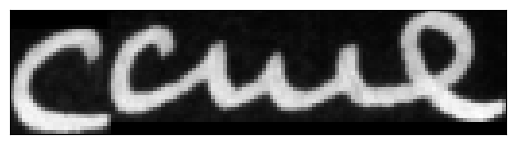



original_text =   to
predicted text =  to


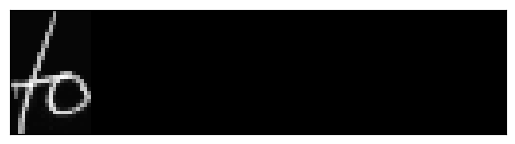



original_text =   heavy
predicted text =  heany


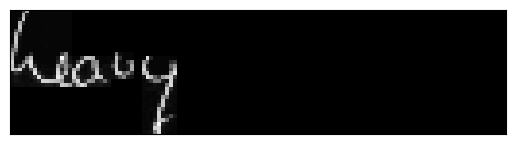



original_text =   .
predicted text =  .


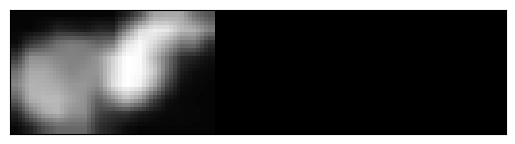



original_text =   not
predicted text =  not


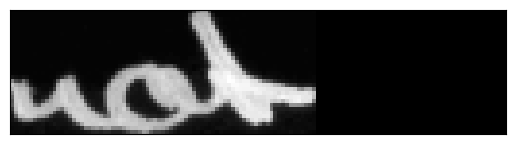



original_text =   the
predicted text =  the


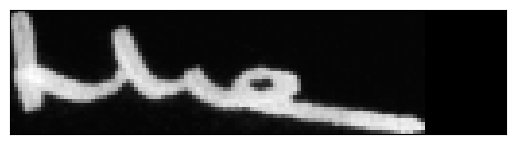



original_text =   .
predicted text =  .


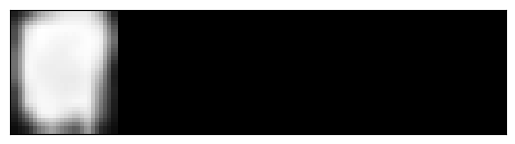



original_text =   ranks
predicted text =  ramk


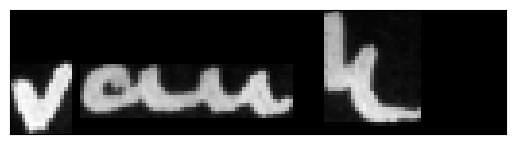



original_text =   this
predicted text =  this


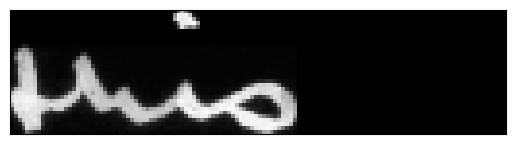



original_text =   medicine
predicted text =  edicine


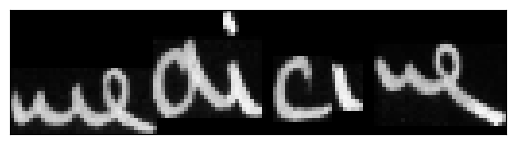

In [ ]:
prediction = act_model.predict(valid_images[150:160])

decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]

out = K.get_value(decoded)

for i, x in enumerate(out):

  pred_str = ""

  for p in x:

    if int(p) != -1:

      pred_str += char_list[int(p)]

  print("original_text =  ", valid_original_text[150+i])

  print("predicted text = ", pred_str)

  plt.imshow(valid_images[150+i].reshape(32,128), cmap=plt.cm.gray)

  plt.xticks([])

  plt.yticks([])

  plt.show()

  print('\n')

# Load The Model

In [9]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/ml_project/handwritten_act_word_model.h5', custom_objects={
    'ctc_lambda_func': ctc_lambda_func,  # If you're using the custom ctc loss function
    'SqueezeLayer': SqueezeLayer,
    'AttentionLayer': AttentionLayer
})


In [ ]:
# Load a new custom image
new_image_path = f'{loaytamer_custom_dataset_path}/loay.png'
new_img = cv2.imread(new_image_path, cv2.IMREAD_GRAYSCALE)

if new_img is not None:
    new_img_processed = process_image(new_img)
    new_img_processed = np.expand_dims(new_img_processed, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = loaded_model.predict(new_img_processed)

    # Decode the prediction
    decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
    output_text = K.get_value(decoded)

    # Convert numeric labels back to characters
    char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    pred_str = ''.join([char_list[int(p)] for p in output_text[0] if int(p) != -1])

    print("Predicted Text:", pred_str)
else:
    print("Error loading the image.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Predicted Text: loay


# Deployment

In [ ]:
! pip install flask

In [15]:
def handwritten_prediction(path):
  new_image_path = path
  new_img = cv2.imread(new_image_path, cv2.IMREAD_GRAYSCALE)
  pred_str = 'Error loading the image.'
  if new_img is not None:
      new_img_processed = process_image(new_img)
      new_img_processed = np.expand_dims(new_img_processed, axis=0)  # Add batch dimension

      # Make a prediction
      prediction = loaded_model.predict(new_img_processed)

      # Decode the prediction
      decoded = K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0]) * prediction.shape[1], greedy=True)[0][0]
      output_text = K.get_value(decoded)

      # Convert numeric labels back to characters
      char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
      pred_str = ''.join([char_list[int(p)] for p in output_text[0] if int(p) != -1])

      return pred_str


In [16]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://w7pm9dxk5y-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [18]:
from flask import Flask, render_template, request, redirect, url_for
import os
app = Flask(__name__,template_folder='/content/drive/MyDrive/ml_project/templates')
app.config['UPLOAD_FOLDER'] = '/content/drive/MyDrive/ml_project/uploads'
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)


In [19]:
@app.route("/", methods=["GET", "POST"])
def home():
    if request.method == "POST":
        # Check if the file was uploaded
        if "file" not in request.files:
            return "No file uploaded"
        file = request.files["file"]
        if file.filename == "":
            return "No file selected"
        if file:
            # Save the file
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], file.filename)
            file.save(file_path)
            # Process the file
            result = handwritten_prediction(file_path)
            return render_template("result.html", result=result)
    return render_template("index.html")


In [20]:
if __name__ == "__main__":
  app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:56:47] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:56:48] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:57:14] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:57:14] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:57:21] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:57:21] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:57:27] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:57:27] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:57:33] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:57:33] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:58:41] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:58:42] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:58:43] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:58:43] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:58:48] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:58:49] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:58:49] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:58:50] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:14] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:15] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:17] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:17] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:26] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:26] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:27] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:28] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:33] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:34] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:35] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:36] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:41] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 19:59:42] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 20:00:46] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 20:00:47] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 20:00:51] "POST /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 20:00:51] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 20:01:07] "GET /?authuser=0 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Dec/2024 20:01:07] "GET /favicon.ico?authuser=0 HTTP/1.1" 404 -
